In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [2]:
device = 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = v2.Compose([
    v2.ToTensor(),
])

train_complete_set = torchvision.datasets.MNIST('./datasets', train=True, transform=transforms, download=True)
train_set, val_set = random_split(train_complete_set, [0.95, 0.05], torch.Generator().manual_seed(42))

test_set = torchvision.datasets.MNIST('./datasets', train=False, transform=transforms, download=True)

c:\Users\F\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [280]:
batch_size = 256

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=2, pin_memory=True)

In [348]:
class Solver:
    def __init__(self, model, lr=3e-3, reg=0.0, optim=torch.optim.Adam, batch_size=batch_size, criterion=nn.CrossEntropyLoss, print_every=100, anneal=False):
        self.lr = lr
        self.reg = reg
        self.model = model
        self.batch_size = batch_size
        self.optim = optim(model.parameters(), lr=lr, weight_decay=reg)
        self.criterion = criterion(reduction="mean")
        self.dataloaders = {}
        self.loss_history = []
        self.print_every = print_every
        self.kl_loss_weight = 1.0

        self.anneal = anneal
        self.anneal_counter = 0
        self.last_anneal_idx = 0
        self.max_anneal_count = 3

    def set_data_loader(self, loader, split):
        self.dataloaders[split] = loader

    def estimate_loss(self, split):
        dataloader = self.dataloaders[split]

        if dataloader == None:
            return -1.0

        self.model.eval()
        avg_loss = 0.0
        avg_kl_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                if i % 5000 == 0 and i > 0:
                    break
                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                out, mean, log_var  = self.model(images)
                reconn_loss = self.criterion(out, images)
                kl_loss = 0.5 * (mean.square() + log_var.exp() - 1 - log_var).sum()

                loss = reconn_loss
                avg_loss += loss.item()
                avg_kl_loss += kl_loss.item()

        self.model.train()
        print(f"{split} reconn loss: {avg_loss / len(dataloader)}, kl loss: {avg_kl_loss / len(dataloader)}")
        return (avg_loss / len(dataloader)) # + (avg_kl_loss / len(dataloader))
    
    def anneal_learning_rate(self):
        num_losses = len(self.loss_history)
        if (self.anneal_counter == self.max_anneal_count
            or num_losses < 3
            or num_losses - self.last_anneal_idx < 3):
            return

        train = [l[0] for l in self.loss_history]
        arr = np.array(train[-3:])
        if arr.std() >= 1e-4:
            return

        self.last_anneal_idx = num_losses
        self.anneal_counter += 1
        print(f"Annealing learning_rate {self.lr} by 10. New learning rate {self.lr / 10}. Anneal count {self.anneal_counter} / {self.max_anneal_count}.")
        self.lr /= 10

    def train(self, loader, epochs=1):
        for e in range(epochs):
            for i, data in enumerate(loader):

                # if i % self.print_every == 0 and i > 0:
                #     train_loss = self.estimate_loss('train')
                #     val_loss = self.estimate_loss('val')
                    
                #     print(f"epoch: {e} iter: {i} train_loss: {train_loss} val_loss: {val_loss}")

                #     self.loss_history.append((train_loss, val_loss))
                #     if self.anneal:
                #         self.anneal_learning_rate()

                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                self.optim.zero_grad()

                out, mean, log_var  = self.model(images)
                out.retain_grad = True
                reconn_loss = self.criterion(out, images)

                loss = reconn_loss
                kl_loss = 0.5 * (mean.square() + log_var.exp() - 1 - log_var).sum()
                loss += kl_loss
                print(f"epoch: {e} iter: {i} reconn_loss: {reconn_loss} kl_loss: {kl_loss}")


                loss.backward()
                self.optim.step()

                self.kl_loss_weight = self.kl_loss_weight + 0.001
            
            for p in self.model.decoder.named_parameters():
              print(p[0], p[1].grad.max(), p[1].grad.min())

In [349]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.encoder = nn.Sequential(
            nn.Linear(in_channels, 512, device=device),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.3),
            nn.Linear(512, 64, device=device),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.3),
            nn.Linear(64, out_channels, device=device),
        )

        self.decoder = nn.Sequential(
            nn.Linear(out_channels, 64, device=device),
            nn.LeakyReLU(0.02),
            nn.Linear(64, 512, device=device),
            nn.LeakyReLU(0.02),
            nn.Linear(512, in_channels, device=device),
            nn.Sigmoid()
        )
        self.ln_mean = nn.Linear(out_channels, out_channels, device=device)
        self.ln_var  = nn.Linear(out_channels, out_channels, device=device)

    def forward(self, input):
        mean, log_var = self.encode(input)
        q = self.reparameterize(mean, log_var)
        x = self.decode(q)
        return [x, mean, log_var]
    
    def encode(self, x):
        encoded = self.encoder(x)
        mean = self.ln_mean(encoded)
        log_var  = self.ln_var(encoded)
        
        return [mean, log_var]

    def reparameterize(self, mean, log_var):
        std = z = torch.exp(0.5 * log_var)
        eps  = torch.randn_like(std, requires_grad=False)

        return mean + (std * eps)


    def decode(self, embd):
        return self.decoder(embd)

In [350]:
print(device)
model = Net(784, 75).to(device)

cpu


In [351]:
solver = Solver(model, lr=0.0003, batch_size=batch_size, criterion=nn.MSELoss, print_every=2)
solver.set_data_loader(train_loader, 'train')
solver.set_data_loader(val_loader, 'val')

In [373]:
# solver.lr = solver.lr / 100
solver.train(train_loader, 20)

epoch: 0 iter: 0 reconn_loss: 12489.8779296875 kl_loss: 777.7919311523438
epoch: 0 iter: 1 reconn_loss: 12078.287109375 kl_loss: 833.5556030273438
epoch: 0 iter: 2 reconn_loss: 12106.95703125 kl_loss: 841.2825317382812
epoch: 0 iter: 3 reconn_loss: 12186.634765625 kl_loss: 927.784423828125
epoch: 0 iter: 4 reconn_loss: 12126.1328125 kl_loss: 915.503662109375
epoch: 0 iter: 5 reconn_loss: 11909.6201171875 kl_loss: 907.7681884765625
epoch: 0 iter: 6 reconn_loss: 12177.3017578125 kl_loss: 897.4285278320312
epoch: 0 iter: 7 reconn_loss: 11746.009765625 kl_loss: 955.491455078125
epoch: 0 iter: 8 reconn_loss: 11602.4716796875 kl_loss: 881.835205078125
epoch: 0 iter: 9 reconn_loss: 12305.63671875 kl_loss: 854.3868408203125
epoch: 0 iter: 10 reconn_loss: 11772.3984375 kl_loss: 796.670166015625
epoch: 0 iter: 11 reconn_loss: 12141.5458984375 kl_loss: 822.266845703125
epoch: 0 iter: 12 reconn_loss: 12003.0341796875 kl_loss: 863.9511108398438
epoch: 0 iter: 13 reconn_loss: 11781.4189453125 kl_los

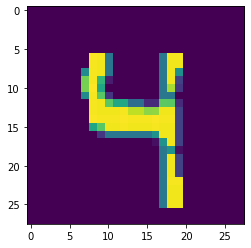

In [374]:
img = train_set[51][0]
plt.imshow(img.reshape(28, 28))

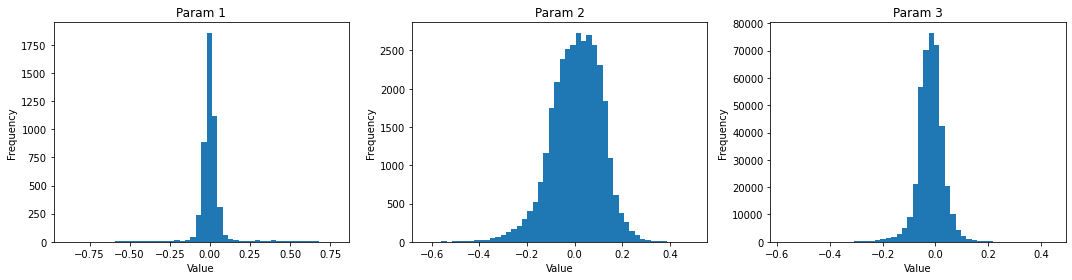

In [375]:
params = [p[1].flatten().detach().numpy() for p in model.decoder.named_parameters() if p[0].find("weight") != -1]
num_params = len(params)
cols = min(3, num_params)  # adjust layout
rows = (num_params + cols - 1) // cols  # ceil division

plt.figure(figsize=(cols * 5, rows * 4))

for i, param in enumerate(params, 1):
    plt.subplot(rows, cols, i)
    plt.hist(param, bins=50)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Param {i}")

plt.tight_layout()
plt.show()

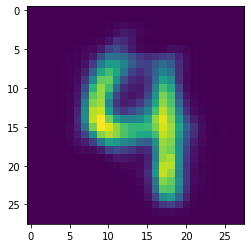

In [418]:
x, mean, log_var = model(img.to(device).reshape(1, 784))

plt.imshow(x.reshape(28, 28).cpu().detach().numpy())

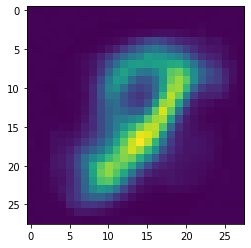

In [410]:
randimg = torch.rand(1, 75, device=device)
out = model.decoder(randimg)
plt.imshow(out.reshape(28, 28).cpu().detach().numpy())